In [ ]:
!pip install pymongo

In [ ]:
import pandas as pd
from pymongo import MongoClient
from sklearn.preprocessing import OneHotEncoder

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam , Adagrad , RMSprop , SGD
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
data = list(collection.find())
df = pd.DataFrame(data)
df = df.drop(columns=['_id'])
df

,traffic_volume,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time
0,5545,NaN,288.28,0.0,0.0,40,Clouds,scattered clouds,02-10-2012 09:00
1,4516,NaN,289.36,0.0,0.0,75,Clouds,broken clouds,02-10-2012 10:00
2,4767,NaN,289.58,0.0,0.0,90,Clouds,overcast clouds,02-10-2012 11:00
3,5026,NaN,290.13,0.0,0.0,90,Clouds,overcast clouds,02-10-2012 12:00
4,4918,NaN,291.14,0.0,0.0,75,Clouds,broken clouds,02-10-2012 13:00
...,...,...,...,...,...,...,...,...,...
48199,3543,NaN,283.45,0.0,0.0,75,Clouds,broken clouds,30-09-2018 19:00
48200,2781,NaN,282.76,0.0,0.0,90,Clouds,overcast clouds,30-09-2018 20:00
48201,2159,NaN,282.73,0.0,0.0,90,Thunderstorm,proximity thunderstorm,30-09-2018 21:00
48202,1450,NaN,282.09,0.0,0.0,90,Clouds,overcast clouds,30-09-2018 22:00


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   traffic_volume       48204 non-null  int64  
 1   holiday              61 non-null     object 
 2   temp                 48204 non-null  float64
 3   rain_1h              48204 non-null  float64
 4   snow_1h              48204 non-null  float64
 5   clouds_all           48204 non-null  int64  
 6   weather_main         48204 non-null  object 
 7   weather_description  48204 non-null  object 
 8   date_time            48204 non-null  object 
dtypes: float64(3), int64(2), object(4)
memory usage: 3.3+ MB


In [ ]:
df['date_time'] = pd.to_datetime(df['date_time'], format='%d-%m-%Y %H:%M')

df['day_of_week'] = df['date_time'].dt.day_name()

print(df[['date_time', 'day_of_week']].head())


            date_time day_of_week
0 2012-10-02 09:00:00     Tuesday
1 2012-10-02 10:00:00     Tuesday
2 2012-10-02 11:00:00     Tuesday
3 2012-10-02 12:00:00     Tuesday
4 2012-10-02 13:00:00     Tuesday


In [ ]:
df['hour'] = df['date_time'].dt.hour


In [ ]:
traffic_volume = df['traffic_volume'].describe()
traffic_volume

,traffic_volume
count,48204.000000
mean,3259.818355
std,1986.860670
min,0.000000
25%,1193.000000
50%,3380.000000
75%,4933.000000
max,7280.000000


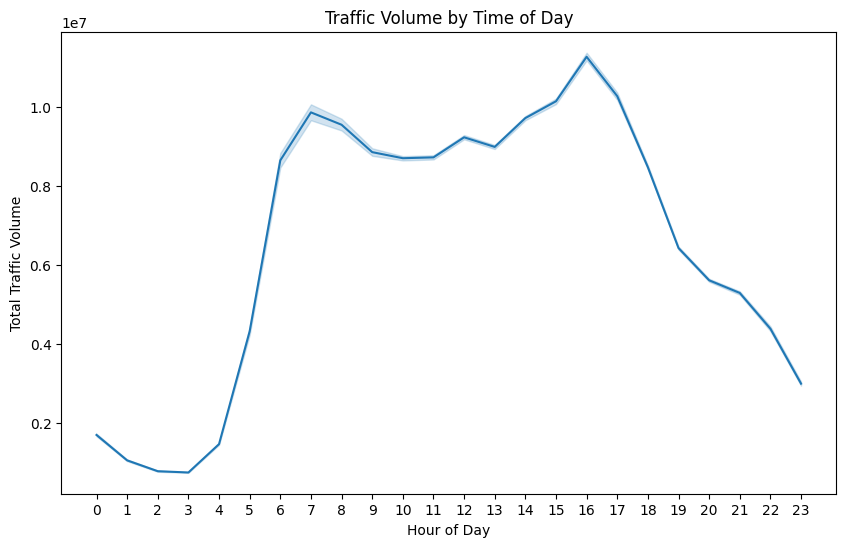

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='hour', y='traffic_volume', estimator='sum')
plt.title('Traffic Volume by Time of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Total Traffic Volume')
plt.xticks(ticks=range(0, 24))
plt.show()

<ipython-input-219-f4974de1bc55>:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df, x='day_of_week', y='traffic_volume', estimator='sum', ci=None)


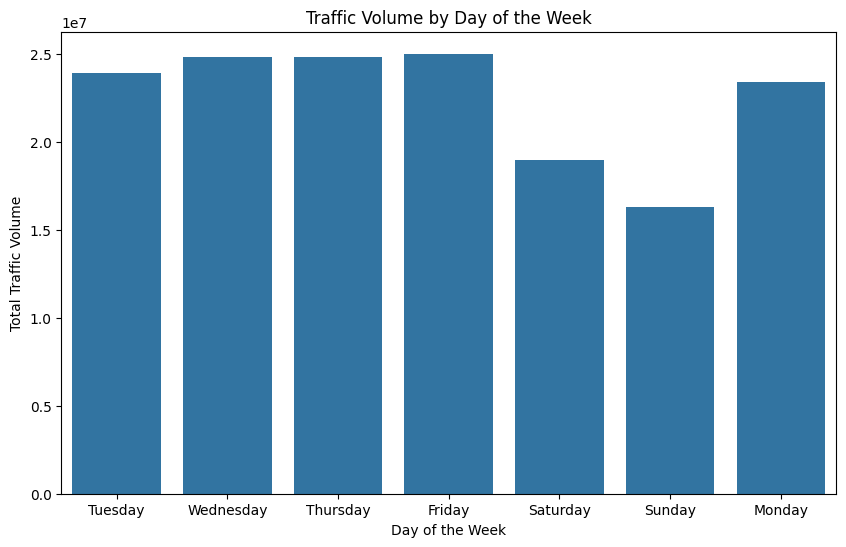

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(data=df, x='day_of_week', y='traffic_volume', estimator='sum', ci=None)
plt.title('Traffic Volume by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Total Traffic Volume')
plt.show()

<ipython-input-220-f0c6407dadb7>:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df, x='weather_main', y='traffic_volume', estimator='sum', ci=None)


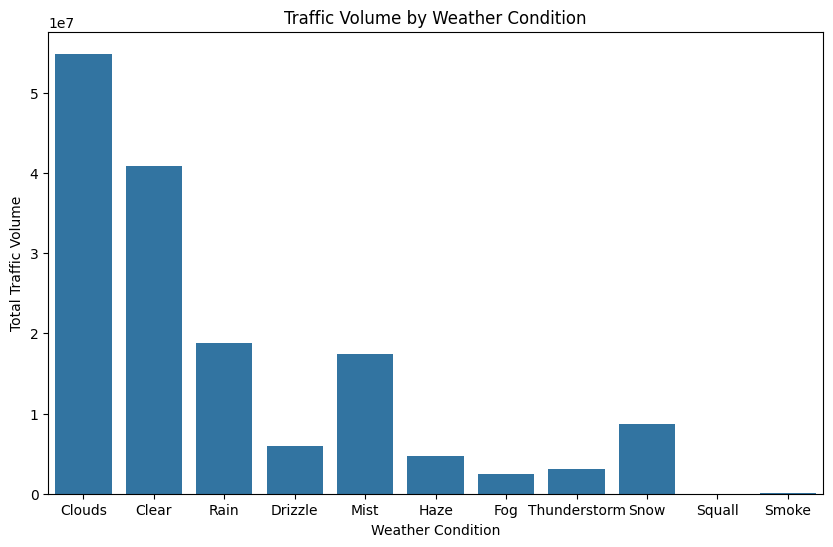

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(data=df, x='weather_main', y='traffic_volume', estimator='sum', ci=None)
plt.title('Traffic Volume by Weather Condition')
plt.xlabel('Weather Condition')
plt.ylabel('Total Traffic Volume')
plt.show()

In [ ]:
threshold = 5000
df['high_traffic'] = df['traffic_volume'].apply(lambda x: 1 if x > threshold else 0)

print(df['high_traffic'].value_counts())

high_traffic
0    36862
1    11342
Name: count, dtype: int64


In [ ]:
# rush hour periods
morning_rush_hours = range(6, 8)  # 6 am to 8 am
evening_rush_hours = range(16, 18)  # 4:00 PM to 6:00 PM
threshold = 5000

df['is_rush_hour'] = df['date_time'].dt.hour.apply(lambda x: 1 if x in morning_rush_hours or x in evening_rush_hours else 0)

df['rush_hour_true'] = df.apply(lambda row: 1 if row['is_rush_hour'] == 1 and row['traffic_volume'] > threshold else 0, axis=1)

df[['date_time', 'traffic_volume', 'is_rush_hour', 'rush_hour_true', 'high_traffic']].head()


,date_time,traffic_volume,is_rush_hour,rush_hour_true,high_traffic
0,2012-10-02 09:00:00,5545,0,0,1
1,2012-10-02 10:00:00,4516,0,0,0
2,2012-10-02 11:00:00,4767,0,0,0
3,2012-10-02 12:00:00,5026,0,0,1
4,2012-10-02 13:00:00,4918,0,0,0


In [ ]:
df

,traffic_volume,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,day_of_week,hour,high_traffic,is_rush_hour,rush_hour_true
0,5545,NaN,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,Tuesday,9,1,0,0
1,4516,NaN,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,Tuesday,10,0,0,0
2,4767,NaN,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,Tuesday,11,0,0,0
3,5026,NaN,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,Tuesday,12,1,0,0
4,4918,NaN,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,Tuesday,13,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48199,3543,NaN,283.45,0.0,0.0,75,Clouds,broken clouds,2018-09-30 19:00:00,Sunday,19,0,0,0
48200,2781,NaN,282.76,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 20:00:00,Sunday,20,0,0,0
48201,2159,NaN,282.73,0.0,0.0,90,Thunderstorm,proximity thunderstorm,2018-09-30 21:00:00,Sunday,21,0,0,0
48202,1450,NaN,282.09,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 22:00:00,Sunday,22,0,0,0


In [ ]:
low_threshold = 1193

# based on the thresholds
df['Is_traffic'] = df['traffic_volume'].apply(lambda x: 0 if x <= low_threshold else (2 if x > threshold else 1))

print(df['Is_traffic'].value_counts())


Is_traffic
1    24809
0    12053
2    11342
Name: count, dtype: int64


In [ ]:
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

In [ ]:
df['season'] = df['date_time'].dt.month.apply(get_season)

df[['date_time', 'season']].head()

,date_time,season
0,2012-10-02 09:00:00,Fall
1,2012-10-02 10:00:00,Fall
2,2012-10-02 11:00:00,Fall
3,2012-10-02 12:00:00,Fall
4,2012-10-02 13:00:00,Fall


In [ ]:
from sklearn.preprocessing import LabelEncoder

columns_to_label_encode = ['season', 'day_of_week']

label_encoder = LabelEncoder()

for column in columns_to_label_encode:
    df[column] = label_encoder.fit_transform(df[column])

df[columns_to_label_encode].head()


,season,day_of_week
0,0,5
1,0,5
2,0,5
3,0,5
4,0,5


In [ ]:
ohe  = OneHotEncoder(sparse_output= False).set_output(transform = 'pandas')
weather_mainOHE = ohe.fit_transform(df[['weather_main']])
df = pd.concat([df,weather_mainOHE] , axis=1).drop(columns=['weather_main'])
df

,traffic_volume,holiday,temp,rain_1h,snow_1h,clouds_all,weather_description,date_time,day_of_week,hour,...,weather_main_Clouds,weather_main_Drizzle,weather_main_Fog,weather_main_Haze,weather_main_Mist,weather_main_Rain,weather_main_Smoke,weather_main_Snow,weather_main_Squall,weather_main_Thunderstorm
0,5545,NaN,288.28,0.0,0.0,40,scattered clouds,2012-10-02 09:00:00,5,9,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4516,NaN,289.36,0.0,0.0,75,broken clouds,2012-10-02 10:00:00,5,10,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4767,NaN,289.58,0.0,0.0,90,overcast clouds,2012-10-02 11:00:00,5,11,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,5026,NaN,290.13,0.0,0.0,90,overcast clouds,2012-10-02 12:00:00,5,12,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4918,NaN,291.14,0.0,0.0,75,broken clouds,2012-10-02 13:00:00,5,13,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48199,3543,NaN,283.45,0.0,0.0,75,broken clouds,2018-09-30 19:00:00,3,19,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
48200,2781,NaN,282.76,0.0,0.0,90,overcast clouds,2018-09-30 20:00:00,3,20,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
48201,2159,NaN,282.73,0.0,0.0,90,proximity thunderstorm,2018-09-30 21:00:00,3,21,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
48202,1450,NaN,282.09,0.0,0.0,90,overcast clouds,2018-09-30 22:00:00,3,22,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df["holiday"].replace(to_replace=df["holiday"].dropna().unique(), value=1, inplace=True)
df["holiday"].fillna(0, inplace=True)
df

,traffic_volume,holiday,temp,rain_1h,snow_1h,clouds_all,weather_description,date_time,day_of_week,hour,...,weather_main_Clouds,weather_main_Drizzle,weather_main_Fog,weather_main_Haze,weather_main_Mist,weather_main_Rain,weather_main_Smoke,weather_main_Snow,weather_main_Squall,weather_main_Thunderstorm
0,5545,0.0,288.28,0.0,0.0,40,scattered clouds,2012-10-02 09:00:00,5,9,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4516,0.0,289.36,0.0,0.0,75,broken clouds,2012-10-02 10:00:00,5,10,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4767,0.0,289.58,0.0,0.0,90,overcast clouds,2012-10-02 11:00:00,5,11,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,5026,0.0,290.13,0.0,0.0,90,overcast clouds,2012-10-02 12:00:00,5,12,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4918,0.0,291.14,0.0,0.0,75,broken clouds,2012-10-02 13:00:00,5,13,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48199,3543,0.0,283.45,0.0,0.0,75,broken clouds,2018-09-30 19:00:00,3,19,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
48200,2781,0.0,282.76,0.0,0.0,90,overcast clouds,2018-09-30 20:00:00,3,20,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
48201,2159,0.0,282.73,0.0,0.0,90,proximity thunderstorm,2018-09-30 21:00:00,3,21,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
48202,1450,0.0,282.09,0.0,0.0,90,overcast clouds,2018-09-30 22:00:00,3,22,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 26 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   traffic_volume             48204 non-null  int64         
 1   holiday                    48204 non-null  float64       
 2   temp                       48204 non-null  float64       
 3   rain_1h                    48204 non-null  float64       
 4   snow_1h                    48204 non-null  float64       
 5   clouds_all                 48204 non-null  int64         
 6   weather_description        48204 non-null  object        
 7   date_time                  48204 non-null  datetime64[ns]
 8   day_of_week                48204 non-null  int64         
 9   hour                       48204 non-null  int32         
 10  high_traffic               48204 non-null  int64         
 11  is_rush_hour               48204 non-null  int64         
 12  rush

In [ ]:
df.drop(columns=['weather_description'], inplace=True)
df = df.drop_duplicates()

In [ ]:
from sklearn.preprocessing import StandardScaler

columns_to_scale = ['temp', 'rain_1h', 'snow_1h', 'clouds_all', 'traffic_volume']

scaler = StandardScaler()

df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

df[columns_to_scale].head()


<ipython-input-232-7c180141fd5d>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])


,temp,rain_1h,snow_1h,clouds_all,traffic_volume
0,0.528785,-0.007481,-0.027295,-0.235510,1.149789
1,0.609638,-0.007481,-0.027295,0.661771,0.631892
2,0.626108,-0.007481,-0.027295,1.046319,0.758221
3,0.667284,-0.007481,-0.027295,1.046319,0.888576
4,0.742896,-0.007481,-0.027295,0.661771,0.834219


In [ ]:
df.drop(columns=['date_time'], inplace=True)
df.drop(columns=['Is_traffic'], inplace=True) #
df.drop(columns=['rush_hour_true'], inplace=True)
df.drop(columns=['high_traffic'], inplace=True)

<ipython-input-233-34648a368093>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=['date_time'], inplace=True)
<ipython-input-233-34648a368093>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=['Is_traffic'], inplace=True) #
<ipython-input-233-34648a368093>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=['rush_hour_true'], inplace=True)
<ipython-input-233-34648a368093>:4: SettingWithCop

In [ ]:
df['traffic_volume']

,traffic_volume
0,1.149789
1,0.631892
2,0.758221
3,0.888576
4,0.834219
...,...
48199,0.142180
48200,-0.241335
48201,-0.554388
48202,-0.911228


In [ ]:
X = df.drop(columns=['traffic_volume'])
y = df['traffic_volume']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
model = Sequential()
model.add(Dense(units=6, input_dim=X_train.shape[1], kernel_initializer='uniform',activation='relu'))
model.add(Dense(units=6, activation='relu'))
model.add(Dense(units=6, activation='relu'))
model.add(Dense(units=1, activation='linear'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_24 (Dense)                     │ (None, 6)                   │             126 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 6)                   │              42 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 6)                   │              42 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 1)                   │               7 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 217 (868.00 B)

 Trainable params: 217 (868.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# history = model.fit(X_train, y_train, batch_size=10, epochs=100, validation_split=0.2)

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

history = model.fit(X_train, y_train, batch_size=10, epochs=30, validation_split=0.2)

Epoch 1/30
3070/3070 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - loss: 0.6050 - mean_absolute_error: 0.6364 - val_loss: 0.2376 - val_mean_absolute_error: 0.3565
Epoch 2/30
3070/3070 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 0.2272 - mean_absolute_error: 0.3491 - val_loss: 0.1729 - val_mean_absolute_error: 0.3065
Epoch 3/30
3070/3070 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - loss: 0.1742 - mean_absolute_error: 0.3075 - val_loss: 0.1413 - val_mean_absolute_error: 0.2704
Epoch 4/30
3070/3070 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 0.1403 - mean_absolute_error: 0.2716 - val_loss: 0.1319 - val_mean_absolute_error: 0.2649
Epoch 5/30
3070/3070 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.1300 - mean_absolute_error: 0.2600 - val_loss: 0.1209 - val_mean_absolute_error: 0.2486
Epoch 6/30
3070/3070 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.1280 - mean_absolute_error: 0.2527 - val_loss: 0.1173 - val_mean_absolute_error: 0.2394
Epoch 7/30
3070/3070 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.1200 - mean_absolu

In [ ]:
y_pred = model.predict(X_test)

300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MSE: {mse}')
print(f'MAE: {mae}')
print(f'R-Squared: {r2}')


MSE: 0.08110246344329673
MAE: 0.1925960585214218
R-Squared: 0.9186222013435412


In [ ]:
model.evaluate(X_test, y_test)

300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0803 - mean_absolute_error: 0.1930


[0.08110246807336807, 0.19259604811668396]

In [ ]:
y_pred = np.argmax(model.predict(X_test), axis=-1)

300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


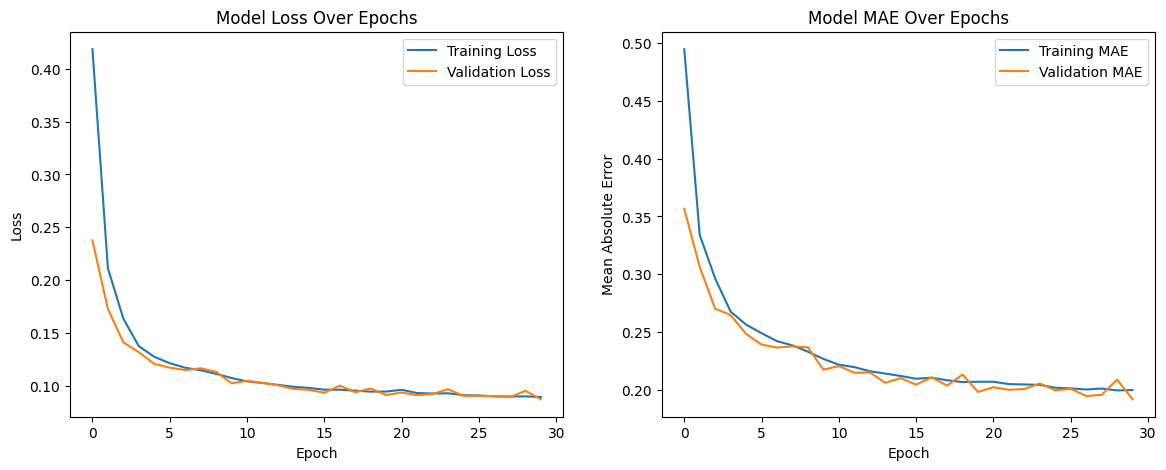

In [ ]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mean_absolute_error'], label='Training MAE')
plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
plt.title('Model MAE Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()

plt.show()

In [ ]:
# print("Classification Report:\n")
# print(classification_report(y_test, y_pred))

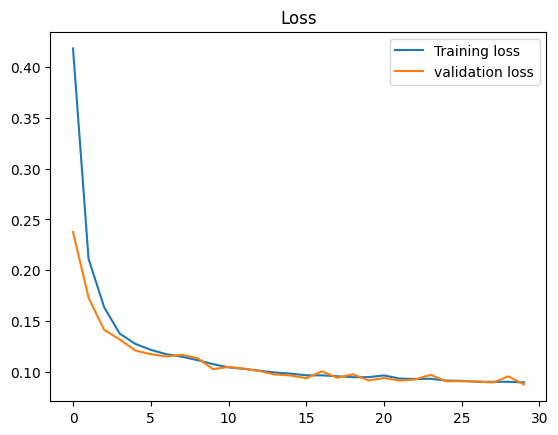

In [ ]:
plt.title('Loss')
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='validation loss')

plt.legend()
plt.show()

KeyError: 'mean_squared_error'

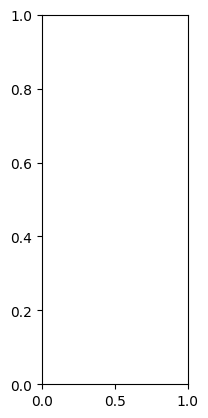

In [ ]:
plt.subplot(1, 3, 3)
plt.plot(history.history['mean_squared_error'], label='Training MSE')
plt.plot(history.history['val_mean_squared_error'], label='Validation MSE')
plt.title('Model MSE Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()